In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    
import warnings
warnings.filterwarnings('ignore')
import pandas as pd


In [2]:
def get_momo():
    return pd.read_csv('https://momo.isciii.es/public/momo/data')

def get_momo_by_year():
    kk = get_momo()

    # Enrich data
    kk = kk[(kk['ambito']=='nacional') &  (kk['nombre_gedad']=='todos')  &    (kk['nombre_sexo' ] =='todos') ]
    kk['date'] =kk['fecha_defuncion'] 
    kk['date'] = pd.to_datetime(kk['date'])
    kk['year'], kk['month'] = kk['date'].dt.year, kk['date'].dt.month
    kk["month"] = kk.month.map("{:02}".format)

    kk['year-month'] =  kk['year'].astype(str) + "-" +  kk['month'].astype(str)

    ss = kk[['defunciones_observadas','year-month']].groupby(['year-month'])['defunciones_observadas'].agg('sum').to_frame()
    ss['month'] = ss.index.astype(str).str[5:7] 
    ss['year-month'] = ss.index

    muertes_2018 = ss[(ss['year-month'] >= '2018-01') & (ss['year-month'] < '2019-01')][['defunciones_observadas','month']]
    muertes_2019 = ss[(ss['year-month'] >= '2019-01') & (ss['year-month'] < '2020-01')][['defunciones_observadas','month']]
    muertes_2020 = ss[(ss['year-month'] >= '2020-01') & (ss['year-month'] < '2021-01')][['defunciones_observadas','month']]

    muertes_2018=muertes_2018.rename(columns = {'defunciones_observadas':'2018'})
    muertes_2019=muertes_2019.rename(columns = {'defunciones_observadas':'2019'})
    muertes_2020=muertes_2020.rename(columns = {'defunciones_observadas':'2020'})


    muertes_2018 = muertes_2018.reset_index(drop=True)
    muertes_2019 = muertes_2019.reset_index(drop=True)
    muertes_2020 = muertes_2020.reset_index(drop=True)

    muertes_temp = pd.merge(  muertes_2019,muertes_2018, on="month", how='left')
    muertes_temp
    muertes_temp2 =  pd.merge(  muertes_2019,muertes_2020, on="month", how='left')
    muertes_temp2
    muertes_totales = pd.merge(  muertes_temp, muertes_temp2)
    muertes_totales.index=muertes_totales
    muertes_totales.index =muertes_totales['month'] 
    del muertes_totales['month']
    return muertes_totales[['2018','2019','2020']]

df=get_momo_by_year()

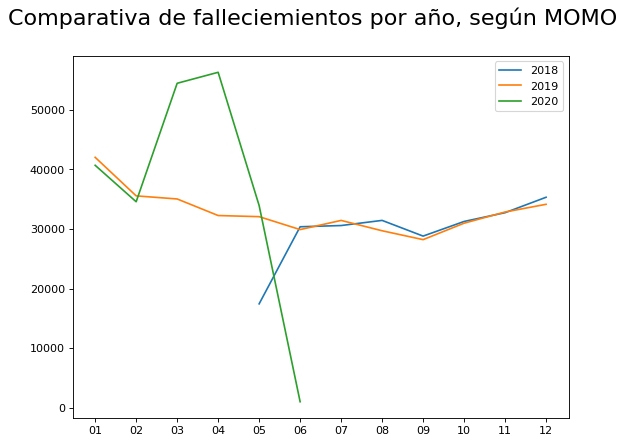

,2018,2019,2020,resta 2020 y 2019
month,,,,
01,nan,"42,034","40,697","-1,337"
02,nan,"35,571","34,584",-987
03,nan,"35,052","54,455","19,403"
04,nan,"32,273","56,299","24,026"
05,"17,459","32,084","33,945","1,861"
06,"30,389","29,915","1,037","-28,878"
07,"30,595","31,454",nan,nan
08,"31,457","29,718",nan,nan
09,"28,824","28,229",nan,nan


In [3]:
from matplotlib import pyplot as plt    
from IPython.display import display, HTML
import pandas as pd

import numpy as np


fig = plt.figure(figsize=(8, 6), dpi=80)
for ca in ['2018','2019','2020']:
    plt.plot(df[ca])
    plt.legend(df.columns)
    fig.suptitle('Comparativa de falleciemientos por año, según MOMO', fontsize=20)
plt.show()

df['resta 2020 y 2019'] = df['2020'] - df['2019']
df

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]


df.style.format({"2020": "{:20,.0f}", 
                          "2018": "{:20,.0f}", 
                          "2019":  "{:20,.0f}", 
                          "resta 2020 y 2019": "{:20,.0f}", }).background_gradient(cmap='Wistia',subset=['resta 2020 y 2019'])



In [4]:
# TO-DO comparativa diaria
"""
df
ss['month'] = ss.index.astype(str).str[5:7] 

ss.index.astype(str).str[5:7] 
"""

"\ndf\nss['month'] = ss.index.astype(str).str[5:7] \n\nss.index.astype(str).str[5:7] \n"

In [5]:
df = get_momo()
df.info
df.describe()

,cod_ine_ambito,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
count,170772.000000,179760.000000,179760.000000,179760.000000,179760.000000,179760.000000,179760.000000
mean,10.000000,37.673114,37.631481,37.724533,36.308143,27.591573,47.810044
std,5.477242,116.138316,116.078340,116.204481,108.427285,95.950863,126.015654
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,2.000000,2.000000,2.000000,2.000000,0.000000,6.310000
50%,10.000000,8.000000,8.000000,8.000000,8.000000,2.690000,15.000000
75%,15.000000,27.000000,27.000000,27.000000,27.000000,16.380000,38.930000
max,19.000000,2963.000000,2963.000000,2963.000000,1337.000000,1186.970000,1702.270000


In [6]:
# Aux functions
def print_categorical_variables(df):
    """ Get a dict with categorical variables"""    
    my_dict = {}
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    # Show categorical values
    categorical = list(set(cols) - set(num_cols))
    for i in categorical : 
        if 'echa' not in i.lower() : my_dict[i] = df[i].unique()         
    return my_dict
df = get_momo()
my_dict = print_categorical_variables(df)
my_dict

{'cod_gedad': array(['all', 'menos_65', '65_74', 'mas_74'], dtype=object),
 'nombre_ambito': array([nan, 'Andalucía', 'Aragón', 'Asturias, Principado de',
        'Balears, Illes', 'Canarias', 'Cantabria', 'Castilla y León',
        'Castilla - La Mancha', 'Cataluña', 'Comunitat Valenciana',
        'Extremadura', 'Galicia', 'Madrid, Comunidad de',
        'Murcia, Región de', 'Navarra, Comunidad Foral de', 'País Vasco',
        'Rioja, La', 'Ceuta', 'Melilla'], dtype=object),
 'nombre_gedad': array(['todos', 'edad < 65', 'edad 65-74', 'edad > 75'], dtype=object),
 'cod_sexo': array(['all', '1', '6'], dtype=object),
 'ambito': array(['nacional', 'ccaa'], dtype=object),
 'cod_ambito': array([nan, 'AN', 'AR', 'AS', 'IB', 'CN', 'CB', 'CL', 'CM', 'CT', 'VC',
        'EX', 'GA', 'MD', 'MC', 'NC', 'PV', 'RI', 'CE', 'ML'], dtype=object),
 'nombre_sexo': array(['todos', 'hombres', 'mujeres'], dtype=object)}